In [1]:
%load_ext autoreload

%autoreload 2

from models import vgg11_PascalVOC, vgg_preprocess
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import _GradCAMPlusPlus, _DeepLiftShap, cut_model_to_layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = vgg_preprocess

In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [4]:
g = nn.Sequential(*list(model.children())[:-2])
h = lambda x : model.classifier(torch.flatten(x, 1))

In [19]:
from tqdm.auto import tqdm
def calculate_erf(model, input, device):
    # input_tensor = torch.tensor(input, device=device, requires_grad=True)
    input_tensor = input.clone().detach().requires_grad_(True).to(device)
    model.eval()
    output = model(input_tensor)

    input_shape = input_tensor.shape
    result = np.zeros(
        (
            output.shape[2],
            output.shape[3],
            input_shape[1],
            input_shape[2],
            input_shape[3],
        )
    )
    for x in range(output.shape[2]):
        for y in range(output.shape[3]):
            input_tensor = input.clone().detach().requires_grad_(True).to(device)
            # Set the model to evaluation mode
            model.eval()

            # Forward pass: compute the output tensor
            output = model(input_tensor)
            # Initialize the output gradient as zero everywhere and 1 at a specific location
            grad_output = torch.zeros_like(output)

            grad_output[0, :, x, y] = 1  # Target a specific output unit

            # Backward pass: compute gradient of the output with respect to the input image
            output.backward(grad_output, retain_graph=True)

            # Retrieve the gradient of the input
            grad_input = input_tensor.grad.data[0].cpu().numpy()
            grad_input = np.abs(grad_input)  # Get the absolute values of the gradients
            grad_input = grad_input / (
                np.max(grad_input) + 1e-6
            )  # Normalize the gradients

            # Save the gradient of the input
            result[x, y] = grad_input

    return result

def calculate_erf_2(model, input, attribution_map, device):
    # input_tensor = torch.tensor(input, device=device, requires_grad=True)
    input_tensor = input.clone().detach().requires_grad_(True).to(device)
    model.eval()
    output = model(input_tensor)

    input_shape = input_tensor.shape
    result = np.zeros(
        (
            output.shape[2],
            output.shape[3],
            input_shape[1],
            input_shape[2],
            input_shape[3],
        )
    )
    # for x in range(output.shape[2]):
        # for y in range(output.shape[3]):
    input_tensor = input.clone().detach().requires_grad_(True).to(device)
    # Set the model to evaluation mode
    model.eval()

    # Forward pass: compute the output tensor
    output = model(input_tensor)
    # Initialize the output gradient as zero everywhere and 1 at a specific location
    grad_output = torch.zeros_like(output)
    for x in range(output.shape[2]):
        for y in range(output.shape[3]):
            # grad_output = torch.zeros_like(output)
                    #

            grad_output[0, :, x, y] = attribution_map[0,0,x,y]  # Target a specific output unit
            # grad_output = torch.tensor(attribution_map, device=device)

    # Backward pass: compute gradient of the output with respect to the input image
    output.backward(grad_output, retain_graph=True)

    # Retrieve the gradient of the input
    grad_input = input_tensor.grad.data[0].cpu().numpy()
    grad_input = np.abs(grad_input)  # Get the absolute values of the gradients
    grad_input = grad_input / (
        np.max(grad_input) + 1e-6
    )  # Normalize the gradients

    # Save the gradient of the input
    result = grad_input

    return result

In [17]:
# import dataset
from data import PascalVOC2007

test_data = PascalVOC2007("test", transform=preprocess)
train_data = PascalVOC2007("train", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


In [11]:
baseline_dist = torch.cat([train_data[i][0].unsqueeze(0) for i in range(16)], dim=0)
print(baseline_dist.shape)

torch.Size([16, 3, 224, 224])


In [7]:
input_tensor = torch.randn(1,3,224,224)
output_tensor = g(input_tensor)
grad_input = calculate_erf(g, torch.randn(1,3,224,224), device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


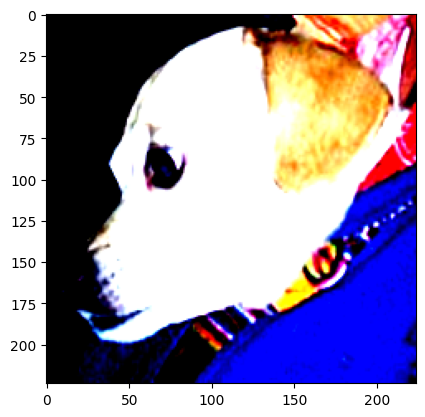

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


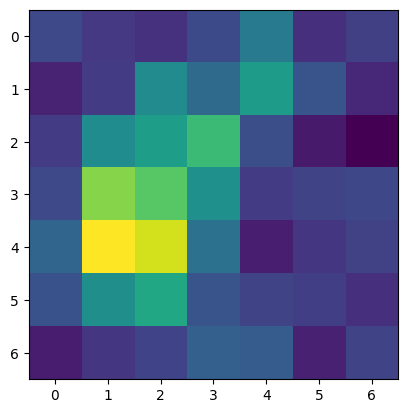

torch.Size([1, 1, 224, 224]) tensor(0.) tensor(1.)


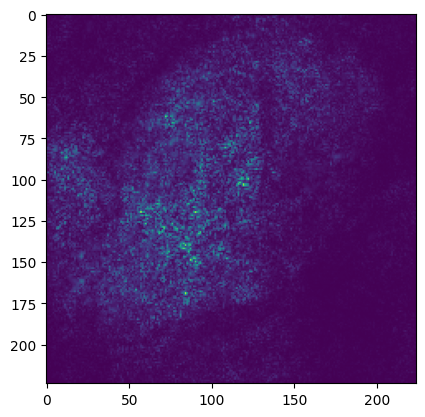

torch.Size([1, 1, 224, 224]) tensor(0.) tensor(1.)


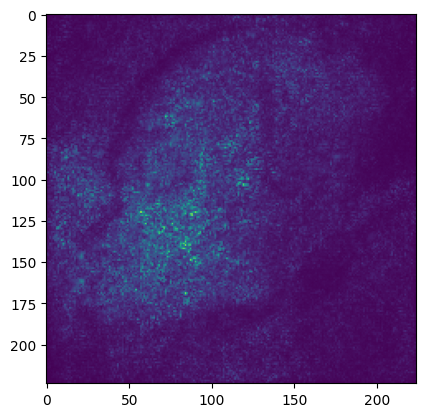

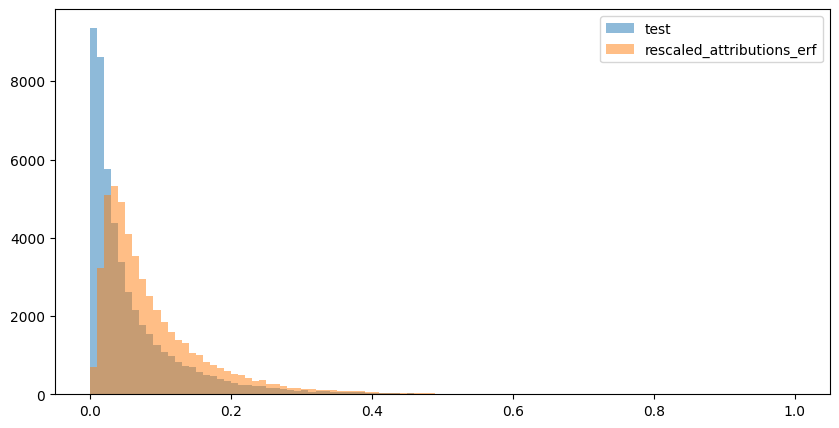

[1.1440297  0.73035985 0.4867482  ... 0.30478674 0.20553586 0.34428552]
0.9441472


C:\Users\Luca\AppData\Local\Temp\ipykernel_14712\2962574343.py:55: RuntimeWarning: divide by zero encountered in divide
  print(test / rescaled_attributions_erf)


In [32]:
from utils import min_max_normalize
for i in [0]:
    image, label = test_data[i]

    plt.imshow(image.permute(1,2,0))
    plt.show()
    images = image.unsqueeze(0).to(device)
    labels = torch.tensor([label]).to(device)
    layer = model.features[-1]

    # attribute_method = _GradCAMPlusPlus(model, target_layer=layer[0])
    attribute_method = _DeepLiftShap()
    attributions = attribute_method.attribute(
                    model=model,
                    input_tensor=images,
                    layer=layer,
                    target=labels,
                    baseline_dist=baseline_dist,
                )
    
    plt.imshow(attributions[0,0].cpu().detach().numpy())
    plt.show()
    
    # attributions = attributions.cpu().detach()
    
    
    from utils import ERFUpsampling
    # print(attributions.shape)
    test = calculate_erf_2(g, images, attributions, device)
    test = torch.tensor(test, device=device)
    test = test.sum(axis=0).unsqueeze(0).unsqueeze(0)
    test = min_max_normalize(test)
    print(test.shape, test.min(), test.max())
    plt.imshow(test[0,0].cpu().detach().numpy())
    plt.show()
    

    up = ERFUpsampling(model, layer,device, post_process_filter=None)
    rescaled_attributions_erf = up(attributions, images)
    print(rescaled_attributions_erf.shape, rescaled_attributions_erf.min(), rescaled_attributions_erf.max())
    plt.imshow(rescaled_attributions_erf[0,0].cpu().detach().numpy())
    plt.show()

    # Plot distribution of both
    plt.figure(figsize=(10,5))
    plt.hist(test.cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label="test")
    plt.hist(rescaled_attributions_erf.cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label="rescaled_attributions_erf")
    plt.legend()
    plt.show()

    # Compute cosine similarity
    test = test.cpu().detach().numpy().flatten()
    rescaled_attributions_erf = rescaled_attributions_erf.cpu().detach().numpy().flatten()

    print(test / rescaled_attributions_erf)

    test = test / np.linalg.norm(test)
    rescaled_attributions_erf = rescaled_attributions_erf / np.linalg.norm(rescaled_attributions_erf)

    
    print(test @ rescaled_attributions_erf.T)
    


    

In [8]:
grad_input.shape

(7, 7, 3, 224, 224)

In [6]:
output_tensor.shape, grad_input.shape

(torch.Size([1, 512, 7, 7]), (7, 7, 3, 224, 224))

In [7]:
single_output = output_tensor[0,:,3,3]
grad = grad_input[3][3]
print(single_output.shape, grad.shape)

torch.Size([512]) (3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


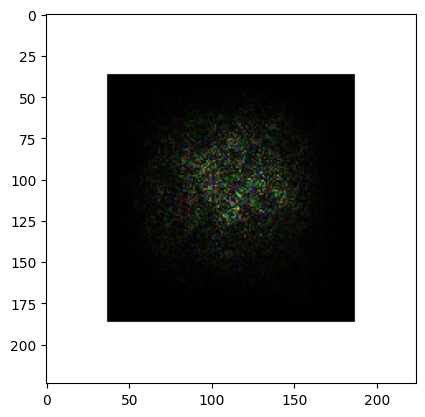

In [8]:
gr = grad.copy()
gr[gr == 0] = 100
plt.imshow(gr.transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


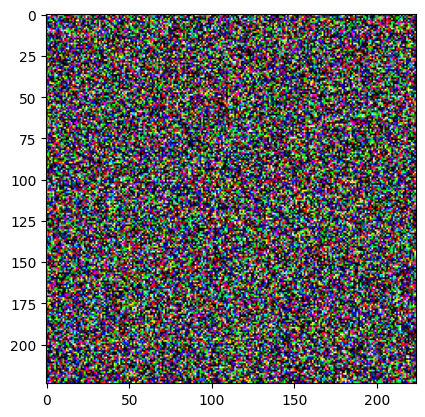

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


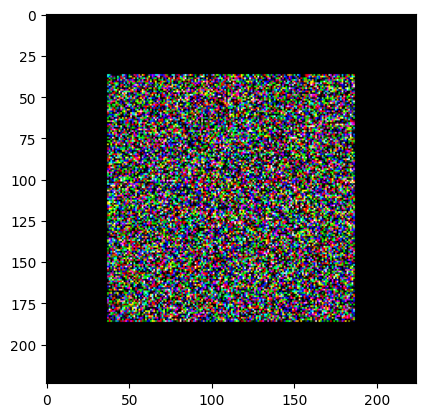

In [9]:
# N = np.arange(20, 150)
# err = []
# for n in N:
# Perturbe only where grad is 0 in order to see if the value does not change
perturbed_input = input_tensor.clone()
plt.imshow(perturbed_input[0].detach().cpu().numpy().transpose(1,2,0))
plt.show()
# zeros = torch.zeros_like(perturbed_input)
# zeros[0,:,:n,:n] = perturbed_input[0,:,:n,:n]
# perturbed_input = zeros
# perturbed_input[0,:,80:,80:] = torch.zeros_like(perturbed_input[0,:,80:,80:])
perturbed_input[0,grad == 0] = torch.zeros_like(perturbed_input[0,grad == 0])
plt.imshow(perturbed_input[0].detach().cpu().numpy().transpose(1,2,0))
plt.show()
output_tensor_perturbed = g(perturbed_input)
single_output_perturbed = output_tensor_perturbed[0,:,3,3]

# err.append(np.linalg.norm(single_output_perturbed.detach().cpu().numpy() - single_output.detach().cpu().numpy()))

In [10]:
np.linalg.norm(single_output_perturbed.detach().cpu().numpy() - single_output.detach().cpu().numpy())

0.0

In [11]:
single_output_perturbed.shape

torch.Size([512])

In [12]:
(single_output - single_output_perturbed).norm()

tensor(0., grad_fn=<LinalgVectorNormBackward0>)

In [67]:
grad_input1 = calculate_erf(g, torch.randn(1,3,224,224), device=device)
grad_input2 = calculate_erf(g, torch.zeros(1,3,224,224), device=device)
grad_input3 = calculate_erf(g, torch.ones(1,3,224,224), device=device)

C:\Users\Luca\AppData\Local\Temp\ipykernel_12132\303834571.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input, device=device, requires_grad=True)


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\Luca\AppData\Local\Temp\ipykernel_12132\303834571.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input, device=device, requires_grad=True)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [68]:
print(np.linalg.norm(grad_input1 - grad_input2))
print(np.linalg.norm(grad_input1 - grad_input3))
print(np.linalg.norm(grad_input2 - grad_input3))

109.25627064566582
109.30211927431213
92.19116288463118


In [37]:
g(torch.randn(1,3,224,224)).shape

torch.Size([1, 512, 7, 7])

In [44]:
from torch_receptive_field import receptive_field, receptive_field_for_unit
receptive_field_dict = receptive_field(cut_model_to_layer(model, "classifier.0", included=False), input_size=(3, 224, 224))

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [224, 224]        0.5        1.0             3.0 
        2             [224, 224]        0.5        1.0             3.0 
        3             [112, 112]        1.0        2.0             4.0 
        4             [112, 112]        1.0        2.0             8.0 
        5             [112, 112]        1.0        2.0             8.0 
        6               [56, 56]        2.0        4.0            10.0 
        7               [56, 56]        2.0        4.0            18.0 
        8               [56, 56]        2.0        4.0            18.0 
        9               [56, 56]        2.0        4.0            26.0 
        10              [56, 56]        2.0        4.0            26.0 
        11              [28, 28]        4.0        8.0   

In [46]:
res = receptive_field_for_unit(receptive_field_dict, "21", (0,0))

Receptive field size for layer 21, unit_position (0, 0),  is 
 [(0, 91.0), (0, 91.0)]


In [47]:
res

[(0, 91.0), (0, 91.0)]

Receptive field size for layer 21, unit_position (0, 0),  is 
 [(0, 91.0), (0, 91.0)]
[(0, 91.0), (0, 91.0)]
Receptive field size for layer 21, unit_position (0, 1),  is 
 [(0, 91.0), (0, 123.0)]
[(0, 91.0), (0, 123.0)]
Receptive field size for layer 21, unit_position (0, 2),  is 
 [(0, 91.0), (5.0, 155.0)]
[(0, 91.0), (5.0, 155.0)]
Receptive field size for layer 21, unit_position (0, 3),  is 
 [(0, 91.0), (37.0, 187.0)]
[(0, 91.0), (37.0, 187.0)]
Receptive field size for layer 21, unit_position (0, 4),  is 
 [(0, 91.0), (69.0, 219.0)]
[(0, 91.0), (69.0, 219.0)]
Receptive field size for layer 21, unit_position (0, 5),  is 
 [(0, 91.0), (101.0, 224)]
[(0, 91.0), (101.0, 224)]
Receptive field size for layer 21, unit_position (0, 6),  is 
 [(0, 91.0), (133.0, 224)]
[(0, 91.0), (133.0, 224)]
Receptive field size for layer 21, unit_position (1, 0),  is 
 [(0, 123.0), (0, 91.0)]
[(0, 123.0), (0, 91.0)]
Receptive field size for layer 21, unit_position (1, 1),  is 
 [(0, 123.0), (0, 123.0)]
[(

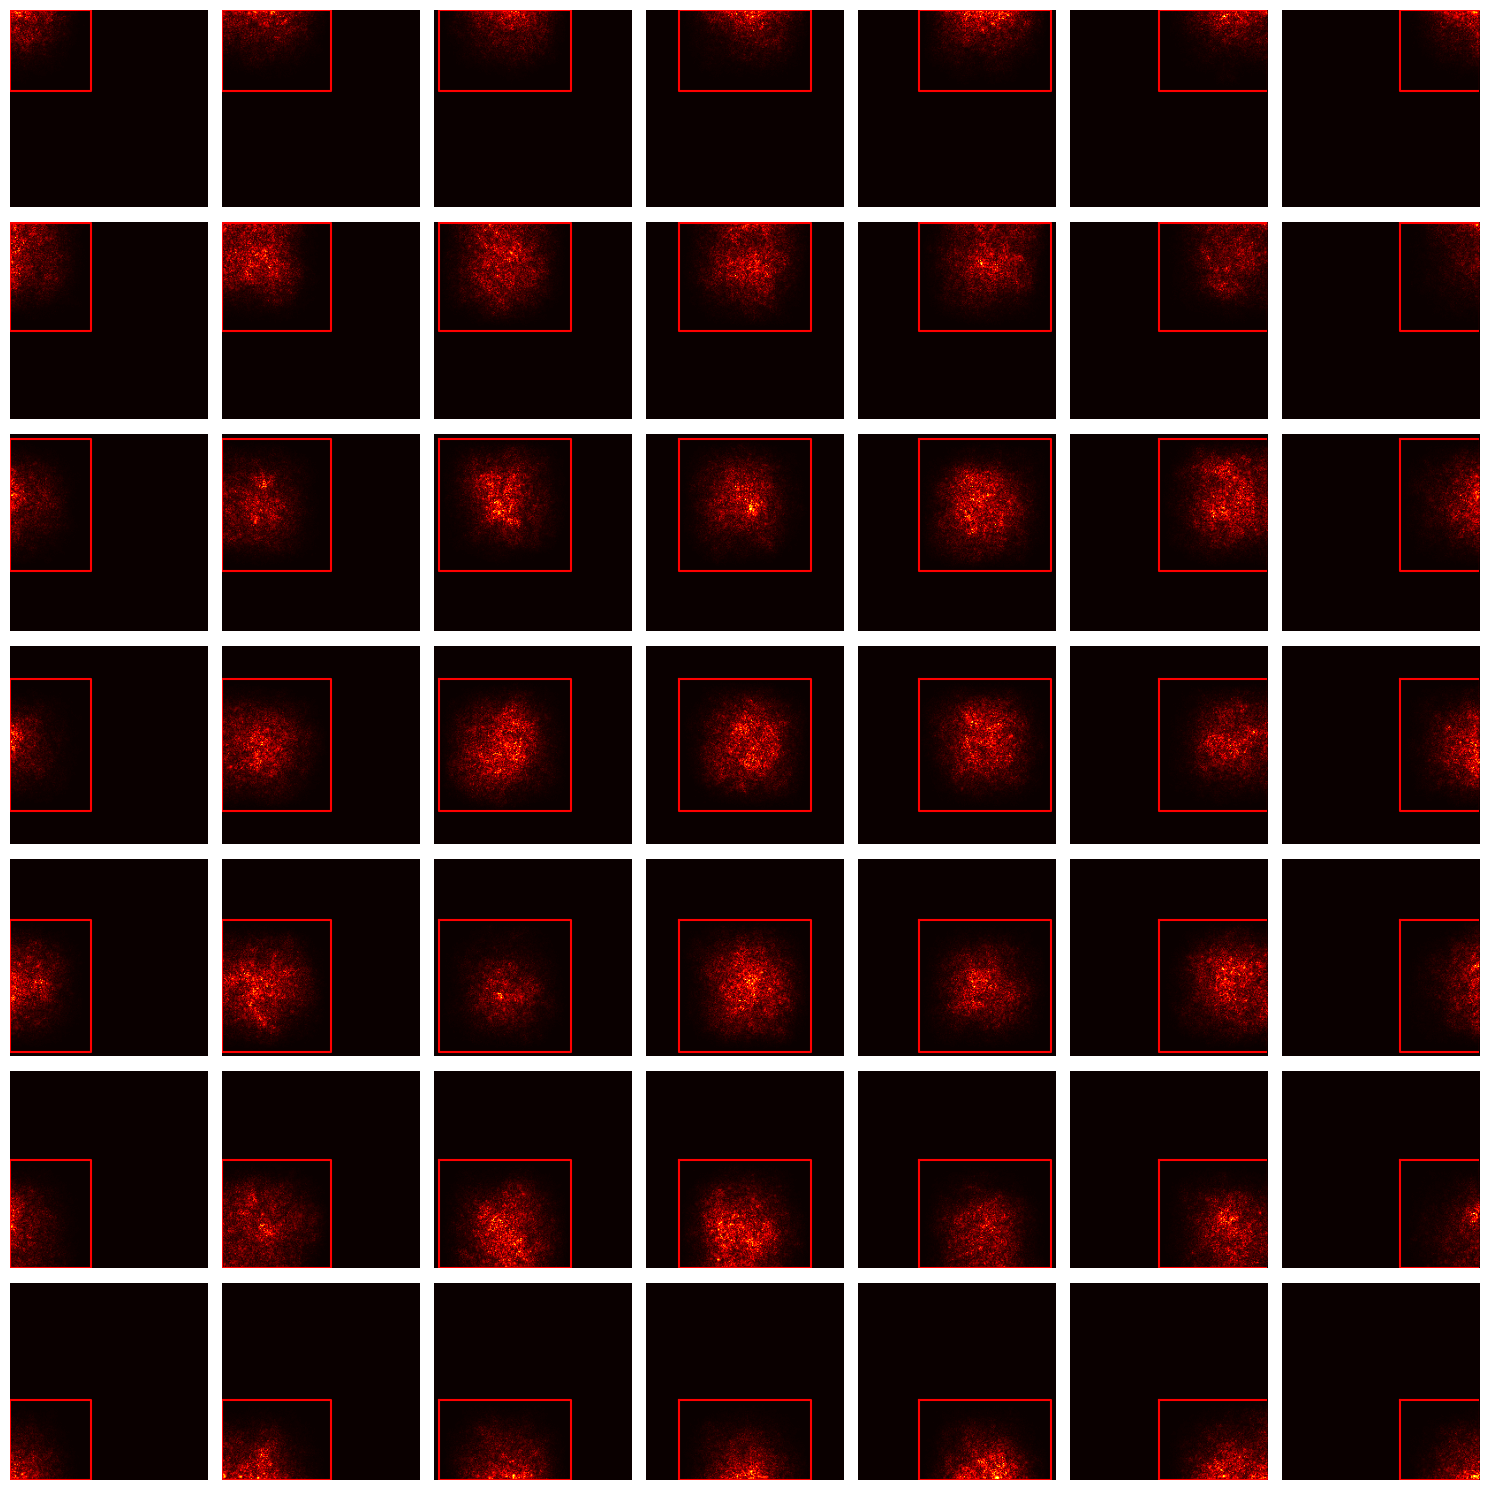

In [59]:
plt.figure(figsize=(15, 15))
for x in range(7):
    for y in range(7):
        rf = receptive_field_for_unit(receptive_field_dict, "21", (x,y))
        print(rf)
        # rf = [(x_min,x_max), (y_min,y_max)]
        # Draw a rectangle around the receptive field
        plt.subplot(7, 7, x * 7 + y + 1)
        plt.plot([rf[1][0], rf[1][0], rf[1][1], rf[1][1], rf[1][0]],
                 [rf[0][0], rf[0][1], rf[0][1], rf[0][0], rf[0][0]],  'r')
        plt.imshow(grad_input[x, y].sum(axis=0), cmap='hot')
        plt.axis('off')

plt.tight_layout()
plt.savefig('./plots/erf.pdf', dpi=600)

In [8]:
def rescale_using_erf(attribution_map, erf_values):
    # attribution_map.shape = (map_H, map_W)
    # erf_values.shape = (map_H, map_W, input_C, input_H, input_W)

    # Rescale the attribution map using the ERF values
    result = np.zeros(erf_values.shape[2:], dtype=np.float32)
    attribution_map = attribution_map.astype(np.float32)

    for i in range(erf_values.shape[0]):
        for j in range(erf_values.shape[1]):
            result += attribution_map[i, j] * erf_values[i, j]
    return result

torch.Size([7, 7])


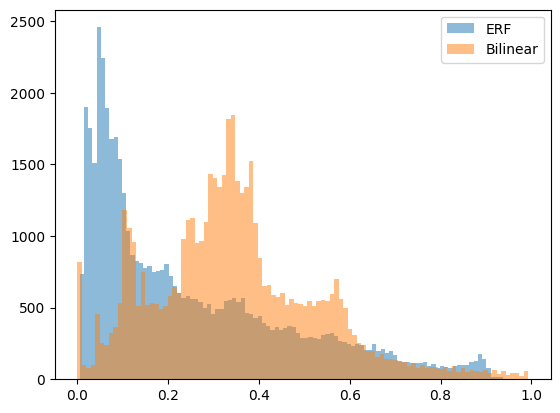

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


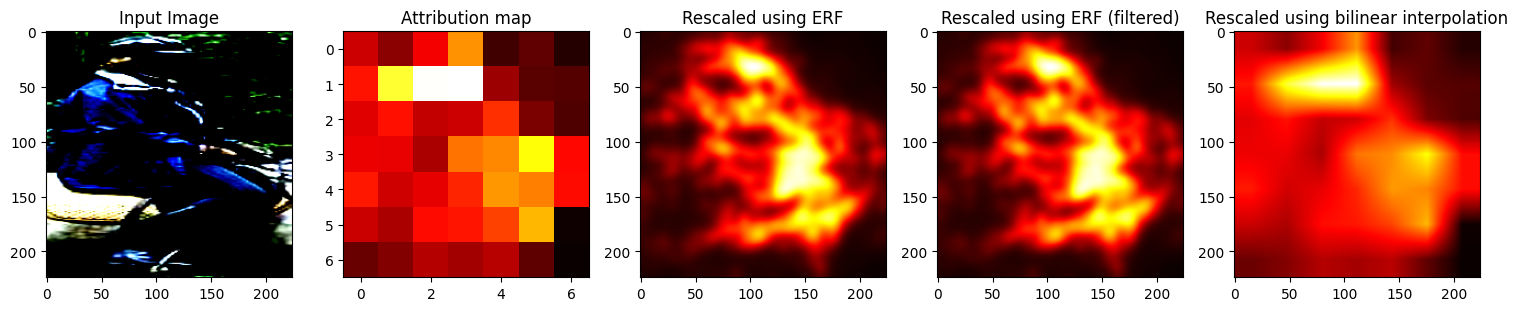

In [19]:
def apply_filter(attribution_map):
    # Apply some filter to the resulting attribution map
    # attribution_map = attribution_map ** (0.5)
    # attribution_map
    # attribution_map[attribution_map > 0.2] = 1
    # Set the top 20% of values to 1
    attribution_map = np.where(attribution_map > np.percentile(attribution_map, 80), 1, attribution_map)

    # Apply gaussian filter using numpy
    from scipy.ndimage import gaussian_filter, median_filter
    # attribution_map = median_filter(attribution_map, size=3)
    attribution_map = gaussian_filter(attribution_map, sigma=5)

    return attribution_map

for i in [30]:
    image, label = test_data[i]

    images = image.unsqueeze(0).to(device)
    labels = torch.tensor([label]).to(device)
    layer = model.features[-1]

    # attribute_method = _GradCAMPlusPlus(model, target_layer=layer[0])
    attribute_method = _DeepLiftShap()
    # attributions = attribute_method.attribute(
    #             input_tensor=images,
    #             model=model,
    #             layer=layer,
    #             target=labels,
    #             baseline_dist=baseline_dist,
    #         )
    attributions = attribute_method.attribute(
                    model=model,
                    input_tensor=images,
                    layer=layer,
                    target=labels,
                    baseline_dist=baseline_dist,
                )
    
    attributions = attributions[0].cpu().detach()[0]
    feature_extractor = cut_model_to_layer(model, layer, included=True)
    
    
    from utils import ERFUpsampling
    # erf = calculate_erf(feature_extractor, images, device=device)
    # plt.figure(figsize=(15, 15))
    # for x in range(7):
    #     for y in range(7):
    #         plt.subplot(7,7,x*7+y+1)
    #         plt.imshow(erf[x,y].sum(axis=0), cmap='hot')
    #         plt.axis('off')
    # plt.show()

    # print(erf.shape)
    print(attributions.shape)

    up = ERFUpsampling(model, layer,device)
    rescaled_attributions_erf = up(attributions.unsqueeze(0).unsqueeze(0), images)

    # rescaled_attributions_erf = rescale_using_erf(attributions.numpy(), erf).sum(axis=0)

    # normalize between 0 and 1
    # rescaled_attributions_erf = (rescaled_attributions_erf - np.min(rescaled_attributions_erf)) / (np.max(rescaled_attributions_erf) - np.min(rescaled_attributions_erf))

    # Plot a distribution of the rescaled attributions using erf
    # rescaled_attributions_erf = apply_filter(rescaled_attributions_erf)

    plt.hist(rescaled_attributions_erf.flatten(), bins=100, label="ERF", alpha=0.5)

    up = nn.Upsample(size=images.shape[2:], mode="bilinear")
    rescaled_attributions_bilinear = up(attributions.unsqueeze(0).unsqueeze(0))[0].sum(0).cpu().detach().numpy()
    
    plt.hist(rescaled_attributions_bilinear.flatten(), bins=100, label="Bilinear", alpha=0.5)
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title("Input Image")
    # plt.show()
    plt.subplot(1, 5, 2)
    plt.imshow(attributions.numpy(), cmap='hot')
    plt.title("Attribution map")

    # plt.figure(figsize=(15, 15))
    plt.subplot(1, 5, 3)
    plt.imshow(rescaled_attributions_erf[0][0], cmap='hot')
    # plt.colorbar()
    plt.title("Rescaled using ERF")

    plt.subplot(1, 5, 4)
    # plt.imshow(rescaled_attributions_bilinear, cmap='hot')
    plt.imshow(rescaled_attributions_erf[0][0], cmap='hot')
    # plt.colorbar()
    plt.title("Rescaled using ERF (filtered)")
    # plt.title("Rescaled using bilinear interpolation")

    plt.subplot(1, 5, 5)
    plt.imshow(rescaled_attributions_bilinear, cmap='hot')
    plt.title("Rescaled using bilinear interpolation")

    plt.tight_layout()
    plt.savefig("./plots/erf_rescale.pdf", dpi=600)
    plt.show()



In [2]:
(224*224*3)*20*200 / (1024**2)

574.21875